In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

## 1 basics
  - $ \theta $ 与 $ \pi_\theta(s,a)$（给定 $\theta$（策略参数） 关于 s, a 的函数），基于 $\theta$ 找到 $\pi_\theta$
    - $\theta$ 是策略参数
    - $\pi_\theta(s,a)$ 是策略 (base $\theta$，policy)
    - $ \pi $ 表示 distribution
    - 策略迭代（策略梯度，policy gradient）的含义
        - $\theta_0\rightarrow \pi_0$, $ \theta_0 \rightarrow \theta_1$, $\theta_1 \rightarrow \\pi_1$

In [19]:
from typing import Optional, Tuple


class MazeEnv(gym.Env):
    def __init__(self) -> None:
        self.state = 0
        self.goal = 8

    def step(self, action: int) -> Tuple[int, float, bool, bool, dict]:
        if action == 0:
            self.state -= 3
        elif action == 1:
            self.state += 1
        elif action == 2:
            self.state += 3
        else:
            self.state -= 1
        return self.state, 1.0, self.state == self.goal, True, {}

    def reset(self, *, seed: int | None = None, options: dict | None = None) -> Tuple[int, dict]:
        self.state = 0
        return self.state


class Agent:
    def _cvt_theta_0_to_pi(self, theta):
        pi = np.zeros_like(theta)

        for r in range(theta.shape[0]):
            pi[r, :] = theta[r, :]/np.nansum(theta[r, :])
        return np.nan_to_num(pi)

    def _softmax_cvt_theta_to_pi(self, theta, beta=1.0):
        pi = np.zeros_like(theta)
        exp_theta = np.exp(beta*theta)
        for r in range(theta.shape[0]):
            pi[r, :] = exp_theta[r, :]/np.nansum(exp_theta[r, :])
        pi = np.nan_to_num(pi)
        return pi

    def __init__(self) -> None:
        self.eta = 0.1

        self.actions = [0, 1, 2, 3]
        self.theta_0 = np.asarray([[np.nan, 1, 1, np.nan],  # s0
                                   [np.nan, 1, np.nan, 1],  # s1
                                   [np.nan, np.nan, 1, 1],  # s2
                                   [1, np.nan, np.nan, np.nan],  # s3
                                   [np.nan, 1, 1, np.nan],  # s4
                                   [1, np.nan, np.nan, 1],  # s5
                                   [np.nan, 1, np.nan, np.nan],  # s6
                                   [1, 1, np.nan, 1],  # s7
                                   #  [np.nan, np.nan, np.nan, 1],  # s8
                                   ])

        self.pi = self._softmax_cvt_theta_to_pi(self.theta_0)
        self.theta = self.theta_0

    def choose_action(self, state: int):
        return np.random.choice(self.actions, p=self.pi[state, :])

    def update_theta(self, s_a_history):
        T = len(s_a_history)-1
        m, n = self.theta.shape
        delta_theta = self.theta.copy()
        for i in range(m):
            for j in range(n):
                if not (np.isnan(self.theta_0[i, j])):
                    sa_i = [sa for sa in s_a_history if sa[0] == i]
                    sa_ij = [sa for sa in s_a_history if sa[0]
                             == i and sa[1] == j]
                    N_i = len(sa_i)
                    N_ij = len(sa_ij)
                    delta_theta[i, j] = (N_ij-self.pi[i, j]*N_i)/T
        self.theta = self.theta + self.eta*delta_theta
        return self.theta

    def update_pi(self, theta):
        self.pi = self._softmax_cvt_theta_to_pi(theta=theta)
        return self.pi

## 4. update the $\theta$ and $\pi_\theta$ base policy gradient
- $\theta_{s_i,a_j}=\theta_{s_i,a_j}+\eta\Delta\theta_{s_i,a_j}$
- $\Delta\theta_{s_i,a_j} = \frac{N(s_i,a_j)-P(s_i,a_j)\cdot N(s_i,a)}{T}$

In [20]:
env = MazeEnv()
state = env.reset()
agent = Agent()
# trajectory
s_a_history = [[state, np.nan]]
# action_history = []
# state_history = [state]
done = False
while not done:
    action = agent.choose_action(state)
    s_a_history[-1][1] = action
    state, reward, done, _, _ = env.step(action=action)
    s_a_history.append([state, np.nan])
len(s_a_history)

13

In [22]:
t = agent.update_theta(s_a_history)
agent._softmax_cvt_theta_to_pi(t)

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.50416657, 0.49583343],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.49583343, 0.50416657, 0.        ],
       [0.49583343, 0.        , 0.        , 0.50416657],
       [0.        , 1.        , 0.        , 0.        ],
       [0.33147637, 0.33704727, 0.        , 0.33147637]])

## 1. render & animation


In [24]:
epsilon = 1e-4

agent = Agent()
env = MazeEnv()

while True:
    state = env.reset()
    s_a_history = [[state, np.nan]]
    done = False
    while not done:
        action = agent.choose_action(state=state)
        s_a_history[-1][1] = action
        state, reward, done, _, _ = env.step(action)
        s_a_history.append([state, np.nan])
    theta = agent.update_theta(s_a_history)
    pi = agent.pi.copy()
    agent.update_pi(theta)
    delta = np.sum(np.abs(agent.pi - pi))
    print(f"len:{len(s_a_history)} loss:{delta}")
    if delta < epsilon:
        break

len:9 loss:0.03679352661295182
len:41 loss:0.01993465393420829
len:51 loss:0.012647627898769498
len:47 loss:0.011869854894245246
len:109 loss:0.004839380981368879
len:29 loss:0.015989073366721618
len:81 loss:0.008933111882608147
len:85 loss:0.007499694616617869
len:19 loss:0.01912795406955009
len:21 loss:0.019840534520223385
len:49 loss:0.012978331243176933
len:19 loss:0.02212446178498756
len:81 loss:0.013623946124684982
len:55 loss:0.00901810173924339
len:27 loss:0.009407677114934287
len:51 loss:0.013269067206368224
len:15 loss:0.024360424575781026
len:23 loss:0.017683253751882455
len:57 loss:0.010602511238332724
len:53 loss:0.008380897101380402
len:51 loss:0.012754117695818079
len:123 loss:0.013847389823819278
len:37 loss:0.016919369933448614
len:93 loss:0.009259851820974885
len:125 loss:0.008690069693860991
len:47 loss:0.01164485852356495
len:47 loss:0.013934130893052232
len:51 loss:0.013646296456676421
len:41 loss:0.014394796479603567
len:53 loss:0.010179089511409722
len:27 loss:0.

In [26]:
agent.pi,s_a_history

(array([[0.        , 0.98801714, 0.01198286, 0.        ],
        [0.        , 0.97836287, 0.        , 0.02163713],
        [0.        , 0.        , 0.98953296, 0.01046704],
        [1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.01461797, 0.98538203, 0.        ],
        [0.01558031, 0.        , 0.        , 0.98441969],
        [0.        , 1.        , 0.        , 0.        ],
        [0.01009652, 0.97846313, 0.        , 0.01144035]]),
 [[0, 1], [1, 1], [2, 2], [5, 3], [4, 2], [7, 1], [8, nan]])

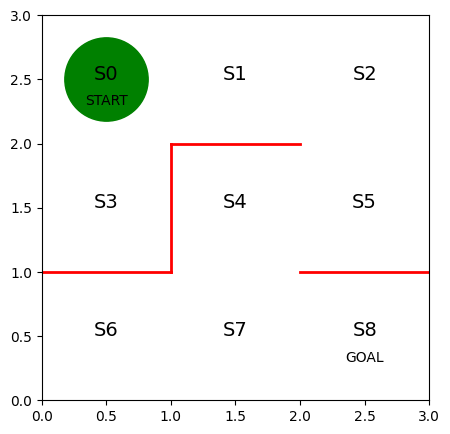

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

plt.plot([2, 3], [1, 1], color='red', linewidth=2)
plt.plot([0, 1], [1, 1], color='red', linewidth=2)
plt.plot([1, 1], [1, 2], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)

plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', size=10, ha='center')
plt.text(2.5, 0.3, 'GOAL', size=10, ha='center')

line, = ax.plot([0.5], [2.5], marker='o', color='green', markersize=60)

In [27]:
from IPython.display import HTML
from matplotlib import animation


def init():
    line.set_data([], [])
    return (line,)


def animate(i):
    state = s_a_history[i][0]
    x, y = (state % 3)+0.5, 2.5-int(state/3)
    line.set_data(x, y)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200)
anim.save("find_goal.gif")
HTML(anim.to_jshtml())

/var/folders/xk/n87yv7vd6qj6v2nsxdv9q8d80000gn/T/ipykernel_83249/4122485094.py:13: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)
/var/folders/xk/n87yv7vd6qj6v2nsxdv9q8d80000gn/T/ipykernel_83249/4122485094.py:13: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(x, y)
